Mutual Information Estimation

In [1]:
import argparse
import collections
import torch
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from trainer import Trainer
from utils import prepare_device
from experiments import get_experiment_config

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
# from torchvision import datasets
# from torchvision.transforms import ToTensor
from jax.nn import one_hot
import math


In [4]:
args = argparse.ArgumentParser(description='PyTorch Template')
args.add_argument('-c', '--config', default=None, type=str,
                      help='config file path (default: None)')
args.add_argument('-r', '--resume', default=None, type=str,
                      help='path to latest checkpoint (default: None)')
args.add_argument('-d', '--device', default=None, type=str,
                  help='indices of GPUs to enable (default: all)')
# args.add_argument("-e", "--exp", type=int, required=True, help="Experiment id")
# args
# args.c = "config.json"
# 

args = args.parse_args(['-c','config.json',])
args.exp = 0#89
# batch_size = 10_000
print(args)
print(type(args))
config = ConfigParser.from_args(args)
config = get_experiment_config(config, config['id'])
# config['data_loader']['args']["additional_feature_names"] =  []
print(config.__dict__)

Namespace(config='config.json', resume=None, device=None, exp=0)
<class 'argparse.Namespace'>
Experiment 0 / 112:
                USE_ECG: True
                USE_HRV: True
                USE_FEATURES: True
                HRV_DURATION: 5m
                ECG_DURATION: 30s
                ADDITIONAL_FEATURES: ['newmultifracs', 'shannon_encoding', 'autoreg']                
{'_config': OrderedDict([('name', 'MyTraining'), ('n_gpu', 1), ('arch', OrderedDict([('type', 'MyModel'), ('args', OrderedDict([('use_ecg_time_series', True), ('use_hrv_time_series', True), ('use_features', True)]))])), ('data_loader', OrderedDict([('type', 'MyDataLoader'), ('args', OrderedDict([('data_dir', 'data/data_patient'), ('batch_size', 16), ('shuffle', True), ('validation_split', 0.2), ('num_workers', 2), ('features_duration', '5m'), ('hrv_duration', '5m'), ('ecg_duration', '30s'), ('additional_feature_names', ['newmultifracs', 'shannon_encoding', 'autoreg'])]))])), ('optimizer', OrderedDict([('type', 'Ada

In [5]:
data_loader = config.init_obj('data_loader', module_data)

In [6]:
dataset = data_loader.dataset
data, label = dataset[:]
Xecg = data["ecg_time_series"].squeeze()
Xhrv = data["hrv_time_series"].squeeze()
Xfeatures = data["features"]

Xecg = np.array(Xecg)
Xhrv = np.array(Xhrv)

features = np.array(Xfeatures)
basic_features = features[:,:6]
multifracs_features = features[:,6:10]
auto_reg_features = features[:,11:16]
shannon_features = features[:,16:]
# Recg = np.array(Recg)
# Rhrv = np.array(Rhrv)
# R = np.array(R)
label = np.array(label)
y = label
y_one_hot = np.array(one_hot(y,4))

# i = 0
# batch = 16
# Recg = []
# Rhrv = []

# with torch.no_grad():
#     while i*batch < Xecg.shape[0]:

#         Recg.append(
#             model.flatten(model.ecg_conv(Xecg[(i*batch):((i+1)*batch)].unsqueeze(1)))
#         )
#         Rhrv.append(
#             model.flatten(model.hrv_conv(Xhrv[(i*batch):((i+1)*batch)].unsqueeze(1)))
#         )
#         i += 1
# Recg = torch.cat(Recg,dim=0)
# Rhrv = torch.cat(Rhrv,dim=0)
# R = torch.cat([Recg,Rhrv,Xfeatures],dim=-1)

Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


In [7]:
df_list = []
for X_ in [features,basic_features,multifracs_features,auto_reg_features,shannon_features]:
    res = evaluate_mi_and_acc(X_,label)
    print(res)
    df_list.append(deepcopy(res))
pd.DataFrame(df_list)

NameError: name 'evaluate_mi_and_acc' is not defined

In [7]:
# data_loader = getattr(module_data, config['data_loader']['type'])(
#         config['data_loader']['args']['data_dir'],
#         batch_size=512,
#         shuffle=False,
#         validation_split=0.0,
#         training=False,
#         num_workers=2
#     )

config['arch']['args']['feature_size'] = data_loader.dataset.get_feature_size()
config['arch']['args']['num_classes'] = data_loader.dataset.get_num_classes()

# build model architecture
model = config.init_obj('arch', module_arch)
# logger.info(model)

# get function handles of loss and metrics
loss_fn = getattr(module_loss, config['loss'])
metric_fns = [getattr(module_metric, met) for met in config['metrics']]

# logger.info('Loading checkpoint: {} ...'.format(config.resume))
checkpoint = torch.load("saved/models/MyTraining/0/0926_144845/model_best.pth") # config.resume)
state_dict = checkpoint['state_dict']
# if config['n_gpu'] > 1:
#     model = torch.nn.DataParallel(model)
# state_dict = 
model.load_state_dict(state_dict)

# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()



MyModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hrv_conv): ConvNet(
    (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
    (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
    (conv3): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
    (conv4): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv5): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv6): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (conv7): Conv1d(32, 256, kernel_size=(3,), stride=(1,))
    (conv8): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (global_maxpool): AdaptiveMaxPool1d(output_size=1)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=256, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=32, bias=True)
  )
  (ecg_conv): ConvNe

In [7]:
# data

In [8]:
# Xecg.shape

In [9]:
# dataset[:5][0]['ecg_time_series'].shape

In [8]:
dataset = data_loader.dataset
data, label = dataset[:]
Xecg = data["ecg_time_series"].squeeze()
Xhrv = data["hrv_time_series"].squeeze()
Xfeatures = data["features"]

i = 0
batch = 16
Recg = []
Rhrv = []

with torch.no_grad():
    while i*batch < Xecg.shape[0]:

        Recg.append(
            model.flatten(model.ecg_conv(Xecg[(i*batch):((i+1)*batch)].unsqueeze(1)))
        )
        Rhrv.append(
            model.flatten(model.hrv_conv(Xhrv[(i*batch):((i+1)*batch)].unsqueeze(1)))
        )
        i += 1
Recg = torch.cat(Recg,dim=0)
Rhrv = torch.cat(Rhrv,dim=0)
R = torch.cat([Recg,Rhrv,Xfeatures],dim=-1)

In [ ]:
print()

In [62]:
# np.array(dataset.raw_hrv)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6480,) + inhomogeneous part.

In [34]:
Xecg = np.array(Xecg)
Xhrv = np.array(Xhrv)

features = np.array(Xfeatures)
basic_features = features[:,:6]
multifracs_features = features[:,6:10]
auto_reg_features = features[:,11:16]
shannon_features = features[:,16:]
Recg = np.array(Recg)
Rhrv = np.array(Rhrv)
R = np.array(R)
label = np.array(label)
y = label
y_one_hot = np.array(one_hot(y,4))

In [68]:
registry.register('lexico',LexicoEntropy)

In [10]:
import pyhrv

In [11]:
from kymatio import Scattering1D

In [12]:
J=4
Q=(8,1)

In [23]:
N = Xhrv.shape[-1]
T = 2 **(int(np.log2(N))+1)
scattering = Scattering1D(J, T, Q)

In [14]:
Sx = []
i=0
batch=16
while i*batch < Xhrv.shape[0]:

    Sx.append(
        scattering(Xhrv[(i*batch):((i+1)*batch),:])
    )
    i += 1
Sx = np.concatenate(Sx,axis=0)

In [15]:
Sx.shape


(6480, 50, 585)

In [16]:
from kymatio.scattering1d.filter_bank import scattering_filter_factory

In [24]:

from kymatio.scattering1d.filter_bank import anden_generator, scattering_filter_factory
filterbank = (anden_generator, {"alpha": 5, "r_psi": np.sqrt(1/2), "sigma0": 5})
phi_f, psi1_f, psi2_f = scattering_filter_factory(N, J, Q, T, filterbank)

ValueError: cannot reshape array of size 9347 into shape (2,newaxis)

In [25]:
phi_f, psi1_f, psi2_f = scattering_filter_factory(T, J, Q, T,filterbank)

In [ ]:
stop

In [ ]:
for hrv in dataset.raw_hrv:
    result = pyhrv.hrv(nni=hrv,show=False, sampling_rate=128)
    

In [ ]:
for hrv in dataset.raw_hrv:
    
    result = pyhrv.hrv(nni=hrv,show=False, sampling_rate=128)
    

In [ ]:
new_X = []

data_transformer = DataTransform(registry,save_data=False)
feature_to_add = 'pyhrv'
for hrv in dataset.raw_hrv:
    
    # print(duration)
    try:
        # print(data_transformer.apply_transformation(hrv,feature_to_add).squeeze())
        
        new_X.append( data_transformer.apply_transformation(hrv[None,:],feature_to_add).squeeze())
    except ValueError:
        print('o')
new_X = np.array(new_X)
saved_X[feature_to_add] = deepcopy(feature_to_add)

In [1]:
new_X.shape

NameError: name 'new_X' is not defined

In [71]:
new_X.shape

(6480,)

In [72]:
print(feature_to_add)

res = evaluate_mi_and_acc(new_X[:,None],label)
res

lexico


  8%|████                                                  | 750/10000 [00:10<02:03, 74.63step/s, test=0.16, train=0.13]


epoch: 100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


{'KNN': 0.24049207792367433,
 'KERNEL': 0.20362968517802338,
 'MINE': 0.18936395645141602,
 'KNIFE': 0.25356995519020686,
 'ACCURACY': 0.4412037037037037}

In [67]:
res

{'KNN': 0.5085069990041888,
 'KERNEL': -0.3809187289303346,
 'MINE': 0.43961119651794434,
 'KNIFE': 0.5011519746699677,
 'ACCURACY': 0.5950617283950618}

pointcare
{'KNN': 0.5085069990041888,
 'KERNEL': -0.3809187289303346,
 'MINE': 0.43961119651794434,
 'KNIFE': 0.5011519746699677,
 'ACCURACY': 0.5950617283950618}

lexico 

{'KNN': 0.24049207792367433,
 'KERNEL': 0.20362968517802338,
 'MINE': 0.18936395645141602,
 'KNIFE': 0.25356995519020686,
 'ACCURACY': 0.4412037037037037}

In [ ]:
pointcare 

## Mutual Information Estimation
### $I(R;Y)$

In [35]:
""" Python implementation of the mutual information estimator proposed by
Ross, 2014, "Mutual Information between Discrete and Continuous Data Sets",
PLOS One. Computes mutual information between a continuous multidimensional
variable and a discrete (categorical) variable, from an array of samples.
The formula for this estimator is
    $$ MI(X, Y) = psi(N) - <psi(N_x)> + psi(k) - <psi(m)> $$
where:
    - psi is the digamma function;
    - N is the number of points;
    - N_x is the number of points of category X=x;
    - k is the number of nearest-neighbors of the same category used to
        estimate the probability density;
    - m is the number of nearest-neighbors of any category within the ball
        extending up to the kth nearest-neighbor of the same category x;
    - <psi(N_x)> and <psi(m)> are averaged over samples of X (each category
        X=x is weighted by the number of occurences of x);
Speed improved by vectorizing some operations, using Scipy's cKDTree
for nearest-neighbor search, and using its multi-code capabilities.
Includes a direct translation in Python of the original Matlab code
provided by Ross 2014, for comparison (it is slower).
WARNING: limited testing of the code was carried out. It worked fine on the
test case provided below and for the authors' use cases, but results are not
guaranteed in other applications (especially with very high-dimensional data).
@authors: François Bourassa (frbourassa), Sooraj Achar (soorajachar)
Spring 2021
"""

import numpy as np
from scipy import special
from scipy.spatial import cKDTree
import psutil


def discrete_continuous_info_fast(d, c, k=3, base=np.e, eps=0):
    """
    Estimates mutual information between a discrete vector d and a continuous
    vector c (can be multidimensional) using nearest-neighbor statistics.
    Relatively fast Python implementation, using Scipy's cKDTree, of the
    estimator described by Ross, 2014, "Mutual Information between Discrete
    and Continuous Data Sets", PLOS One.
    Similar to the estimator described by Kraskov et al., 2004,
    "Estimating Mutual Information", PRE.
    Author of this implementation: Francois Bourassa (Github: frbourassa)
    Args:
        d (np.array): Array of discrete categories. Should be 1-dimensional
        c (np.array): Two-dimensional array or matrix of the continuous data.
            Dimensions should be (n samples x f features)
        k (int): Number of nearest neighbors for density estimation
        base (float): Logarithm base in which the MI is computed (default: e)
        eps (float): Relative tolerance on the radius up to which neighbors
            are included (default: 0, exact computation).
    Returns:
        float: Mutual information estimate
    """
    # Make sure d is an array to allow use of numpy functions
    if type(d) is list:
        d = np.asarray(d, dtype=type(d[0]))
    if d.ndim > 1:
        raise TypeError("d should be a 1d list or array")

    # First, prepare a list of categories according to the discrete symbols d
    numDimensions = c.shape[0]
    categories = list(np.unique(d))
    num_d_symbols = len(categories)

    # Build a KDTree of all points
    main_tree = cKDTree(c, leafsize=max(16, int(k*numDimensions/4)))

    # Number of workers for parallel processing, use half of them.
    n_workers = min(1, psutil.cpu_count() // 2)

    # Check that there are no exactly identical points
    identical_pairs = main_tree.query_pairs(r=0.0, eps=0.0, output_type="ndarray")
    # If any, perturb them slightly to avoid numerical instabilities
    dup_pts = np.unique(identical_pairs[:, 0])
    if identical_pairs.shape[0] > 0:
        # Average nn distance as a perturbation
        perturb = 1e-6*np.mean(main_tree.query(c, k=[2])[0])
        # Perturb the first point of each pair
        c[dup_pts, :] = c[dup_pts, :] + perturb*(np.random.random(size=(dup_pts.shape[0], c.shape[1])) - 0.5)
        # Update the tree
        main_tree = cKDTree(c, leafsize=max(16, int(k*numDimensions/4)))

    # Build an internal tree for each category
    m_tot = 0
    av_psi_Nd = 0
    psi_ks = 0
    for c_bin in range(num_d_symbols):
         # Slice elements in that category, save indices
        ii = (d == categories[c_bin]).nonzero()
        c_split = c[ii]
        numSamplesInBin = c_split.shape[0]
        one_k = min(k, numSamplesInBin-1)

        # For each point in the category, find the radius to its kth
        # nearest-neighbor, and count how many points of any category
        # are in that radius.
        if one_k > 0:
            # Build KDTree with leaf size one_k+2, since we won't need
            # to go much further
            categ_tree = cKDTree(c_split, leafsize=16)

            # Go to one_k+1 because self point is included as a neighbors.
            radii, indices = categ_tree.query(
                                c_split, [one_k+1], eps=eps, workers=n_workers)

            # For each, count how many total points are within that distance.
            # Increase radii a little bit to make sure at least the one_k
            # neighbours in the category are found back
            # (float comparison issues in query in a different tree otherwise)
            m_points_all = main_tree.query_ball_point(
                                c_split, radii.ravel()*(1+1e-15), eps=eps,
                                workers=n_workers, return_length=True)
            m_points_all -= 1  # the query includes the point itself

            # m_tot is \sum_i (psi(m_i))
            m_tot = m_tot + np.sum(special.psi(m_points_all))

        else:  # There was a single point in the category.
            m_tot = m_tot + special.psi(num_d_symbols*2)

        # Probability of each category given by its relative abundance in d
        p_d = numSamplesInBin/len(d)
        # Running estimates of the average digamma terms in the estimator
        av_psi_Nd += p_d*special.psi(p_d*len(d))
        psi_ks = psi_ks + p_d * special.psi(max(one_k, 1))
    # Computing the estimator
    f = special.psi(len(d)) - av_psi_Nd + psi_ks - m_tot/len(d)
    return f / np.log(base)


def discrete_continuous_info_ref(d, c, k=3, base=np.exp(1)):
    """
    Estimates the mutual information between a discrete vector 'd' and a
    continuous vector 'c' using nearest-neighbor statistics.
    Python translation of the estimator coded in Matlab
    Ross, 2014, https://doi.org/10.1371/journal.pone.0087357
    Similar to the estimator proposed by Kraskov et al., 2004,
    "Estimating Mutual Information", PRE.
    Author of the translation: Sooraj Achar (Github: soorajachar)
    Parameters:
        d (np.array): List of discrete categories. Should be 1 dimensional
        c (np.matrix): Matrix of continuous data.
            Dimensions should be n samples x f features
        k (int): Number of nearest neighbors
        base (float): Logarithm base in which the MI is computed (default: e)
    Returns:
        float: Mutual information estimate
    """
    #Make sure d is an array to allow use of numpy functions
    if type(d) is list:
        d = np.array(d, dtype=str)
    #Remove eventually
    if c.shape[1] < c.shape[0]:
        c = c.T
    first_symbol = []
    symbol_IDs = np.zeros(len(d))
    c_split = []
    cs_indices = []
    num_d_symbols = -1
    #First, bin the continuous data "c" according to the discrete symbols "d"
    numDimensions = c.shape[0]
    categories = list(np.unique(d))
    num_d_symbols = len(categories)
    for category in categories:
        ii = np.where(d == category)[0]
        cs_indices.append(ii)
        #Flip later
        c_split.append(c[:, ii])

    m_tot = 0
    av_psi_Nd = 0
    all_c_distances = np.zeros(len(d))
    psi_ks = 0
    for c_bin in range(num_d_symbols):
        numSamplesInBin = c_split[c_bin].shape[1]
        one_k = min(k, numSamplesInBin-1)
        if one_k > 0:
            c_distances = np.zeros([numSamplesInBin])
            for pivot in range(numSamplesInBin):
                # find the radius of our volume using only those samples with
                # the particular value of the discrete symbol 'd'
                for cv in range(numSamplesInBin):
                    vec_diff = (c_split[c_bin][:, cv]
                                    - c_split[c_bin][:, pivot])
                    vec_diff = np.reshape(vec_diff, (-1, c.shape[0])).T
                    c_distances[cv] = np.sqrt(np.dot(vec_diff.T, vec_diff))
                sorted_distances = np.sort(c_distances)
                eps_over_2 = sorted_distances[one_k]   # don't count pivot

                #count the number of total samples within our volume using all
                #  samples (all values of 'd')
                for cv in range(c.shape[1]):
                    vec_diff = c[:, cv] - c_split[c_bin][:, pivot]
                    vec_diff = np.reshape(vec_diff, (-1, c.shape[0])).T
                    all_c_distances[cv] = np.sqrt(np.dot(vec_diff.T, vec_diff))
                # Don't count pivot point
                neigh_all_categs = np.where(all_c_distances <= eps_over_2)
                m = max(len(all_c_distances[neigh_all_categs]) - 1, 0)
                m_tot = m_tot + special.psi(m)

        else:
            m_tot = m_tot + special.psi(num_d_symbols*2)

        p_d = numSamplesInBin/len(d)
        av_psi_Nd = av_psi_Nd + p_d*special.psi(p_d*len(d))
        psi_ks = psi_ks + p_d * special.psi(max(one_k, 1))

    f = special.psi(len(d)) - av_psi_Nd + psi_ks - m_tot/len(d)
    return f / np.log(base)


if __name__ == "__main__":
    # Some test case to make sure both approaches work the same way
    nsamp = 50
    data = np.zeros([nsamp*4, 2])
    target = np.zeros(nsamp*4)
    rndgen = np.random.default_rng(seed=12323452)
    for i in range(4):
        mean = np.asarray([i, i])
        cov = np.eye(2)*(i+1)*0.75
        data[nsamp*i:nsamp*(i+1)] = rndgen.multivariate_normal(
                                            mean=mean, cov=cov, size=nsamp)
        target[nsamp*i:nsamp*(i+1)] = i
    print(data.shape)
    print(target.shape)
    # Reference algorithm with for loops
    mi_ref = discrete_continuous_info_ref(target, data, k=3, base=2)
    print("Reference MI = ", mi_ref)

    # Fast, approximate algorithm using KDTrees and vectorized queries
    mi_fast = discrete_continuous_info_fast(target, data, k=3, base=2)
    msg = "Difference too large to be true: found "+str(mi_fast)
    assert abs(mi_ref - mi_fast) < 1e-10, msg
    print("Fast MI = ", mi_fast)

(200, 2)
(200,)
Reference MI =  0.6659017409639217
Fast MI =  0.6659017409639175


In [36]:
# This code is heavily inspired by sklearn/feature_selection/_mutual_info.py,
# which was written by Nikolay Mayorov <n59_ru@hotmail.com> under the 3-clause
# BSD license.
#
# Author: Jannis Teunissen <jannis.teunissen@cwi.nl>

import numpy as np
from numpy.random import default_rng
from scipy.special import digamma
from sklearn.neighbors import KDTree


def get_radius_kneighbors(x, n_neighbors):
    """Determine smallest radius around x containing n_neighbors neighbors

    :param x: ndarray, shape (n_samples, n_dim)
    :param n_neighbors: number of neighbors
    :returns: radius, shape (n_samples,)

    """
    # Use KDTree for simplicity (sometimes a ball tree could be faster)
    kd = KDTree(x, metric="chebyshev")

    # Results include point itself, therefore n_neighbors+1
    neigh_dist = kd.query(x, k=n_neighbors+1)[0]

    # Take radius slightly larger than distance to last neighbor
    radius = np.nextafter(neigh_dist[:, -1], 0)
    return radius


def num_points_within_radius(x, radius):
    """For each point, determine the number of other points within a given radius

    :param x: ndarray, shape (n_samples, n_dim)
    :param radius: radius, shape (n_samples,)
    :returns: number of points within radius

    """
    kd = KDTree(x, metric="chebyshev")
    nx = kd.query_radius(x, radius, count_only=True, return_distance=False)
    return np.array(nx) - 1.0


def preprocess_data(x):
    """Preprocess data. Ensure x is 2d ndarray, and scale so that the mean absolute
    amplitude of each column is one.

    :param x: ndarray, shape (n_samples,) or (n_samples, n_features)
    :returns: float ndarray, shape (n_samples, n_features)

    """
    x = np.array(x, dtype=np.float64)

    if x.ndim == 1:
        x = x.reshape(-1, 1)
    elif x.ndim != 2:
        raise ValueError(f'x.ndim = {x.ndim}, should be 1 or 2')

    # Estimate mean absolute amplitude per column
    means = np.maximum(1e-100, np.mean(np.abs(x), axis=0))

    # Scale so that mean absolute amplitude is one
    x = (1/means) * x

    return x


def add_noise(x, rng, noise_type='uniform', amplitude=1e-10):
    """Add noise so that samples are probably unique, and convert to float64"""

    if noise_type == 'uniform':
        x += amplitude * (rng.random(x.shape) - 0.5)
    elif noise_type == 'normal':
        x += amplitude * rng.normal(size=x.shape)
    else:
        raise ValueError('Invalid noise type')

    return x


def compute_mi(x, y, n_neighbors=3, noise_type=None):
    """Compute mutual information between two continuous variables.

    :param x: real ndarray, shape (n_samples,) or (n_samples, n_features)
    :param y: real ndarray, shape (n_samples,) or (n_samples, n_features)
    :param n_neighbors: Number of nearest neighbors
    :param noise_type: add noise of given type (uniform, normal)
    :returns: non-negative estimate of mutual information

    """
    n_samples = len(x)
    x, y = [preprocess_data(t) for t in [x, y]]

    if noise_type:
        rng = default_rng()
        x, y = [add_noise(t, rng, noise_type) for t in [x, y]]

    xy = np.hstack((x, y))
    k = np.full(n_samples, n_neighbors)
    radius = get_radius_kneighbors(xy, n_neighbors)

    if noise_type is None:
        # Where radius is 0, determine multiplicity
        mask = (radius == 0)
        if mask.sum() > 0:
            vals, ix, counts = np.unique(xy[mask], axis=0, return_inverse=True,
                                         return_counts=True)
            k[mask] = counts[ix] - 1

    nx = num_points_within_radius(x, radius)
    ny = num_points_within_radius(y, radius)

    mi = max(0, digamma(n_samples) + np.mean(digamma(k))
             - np.mean(digamma(nx + 1)) - np.mean(digamma(ny + 1)))
    return mi


def compute_cmi(x, y, z, n_neighbors=3, noise_type=None):
    """Compute conditional mutual information I(x;y|z)

    :param x: real ndarray, shape (n_samples,) or (n_samples, n_features)
    :param y: real ndarray, shape (n_samples,) or (n_samples, n_features)
    :param z: real ndarray, shape (n_samples,) or (n_samples, n_features)
    :param n_neighbors: Number of nearest neighbors
    :param noise_type: add noise of given type (uniform, normal)
    :returns: non-negative estimate of conditional mutual information

    """
    n_samples = len(x)
    x, y, z = [preprocess_data(t) for t in [x, y, z]]

    if noise_type:
        rng = default_rng()
        x, y, z = [add_noise(t, rng, noise_type) for t in [x, y, z]]

    xyz = np.hstack((x, y, z))
    k = np.full(n_samples, n_neighbors)
    radius = get_radius_kneighbors(xyz, n_neighbors)

    if noise_type is None:
        # Where radius is 0, determine multiplicity
        mask = (radius == 0)
        if mask.sum() > 0:
            vals, ix, counts = np.unique(xyz[mask], axis=0,
                                         return_inverse=True,
                                         return_counts=True)
            k[mask] = counts[ix] - 1

    nxz = num_points_within_radius(np.hstack((x, z)), radius)
    nyz = num_points_within_radius(np.hstack((y, z)), radius)
    nz = num_points_within_radius(z, radius)

    cmi = max(0, np.mean(digamma(k)) - np.mean(digamma(nxz + 1))
              - np.mean(digamma(nyz + 1)) + np.mean(digamma(nz + 1)))
    return cmi


def compute_batch_mi(x, y, n_neighbors=3, noise_type=None):
    N = len(x)
    batch_size = 500
    n_batches = N//batch_size
    mi = np.zeros(n_batches)

    for i in range(n_batches):
        i0 = i * batch_size
        i1 = i0 + batch_size
        mi[i] = compute_mi(x[i0:i1], y[i0:i1], n_neighbors, noise_type)

    return mi.mean()

In [37]:
class BasicDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.FloatTensor(X)
        if torch.is_tensor(Y):
            self.Y = Y
        elif Y.dtype in [int,np.dtype('int64'),np.dtype('int32')] :
            self.Y = torch.LongTensor(Y)
        else:
            self.Y = torch.FloatTensor(Y)
        assert self.X.shape[0] == self.Y.shape[0]
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self,idx):
        return self.X[idx], self.Y[idx]

In [38]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        
        # Create a list of fully connected layers based on the layer sizes
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Add ReLU activation after each layer except the last
                layers.append(nn.ReLU())
        
        # Combine the layers into a Sequential container
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [39]:
class MLPClassifier(nn.Module):
    def __init__(self,input_size, *args, **kwargs):
        hidden_size = 32 #min(64,max(16,input_size))
        super().__init__(*args, **kwargs)
        self.mlp = MLP([input_size,hidden_size,hidden_size,hidden_size,4])

    def forward(self,x):
        return self.mlp(x)

In [40]:
class MINE(nn.Module):
    def __init__(self,zc_dim, zd_dim):
        super(MINE, self).__init__()
        # self.convnet = convnet
        self.net = nn.Sequential(nn.Linear(zc_dim+zd_dim,32),
                                 nn.ReLU(),
                                 nn.Linear(32,32),
                                 nn.ReLU(),
                                 nn.Linear(32,32),
                                 nn.ReLU(),
                                 nn.Linear(32,1))#FF(args, zc_dim + zd_dim, zc_dim, 1)

    def forward(self, z_c, z_d,y=0):  # samples have shape [sample_size, dim]
        # shuffle and concatenate
        # z_c = self.convnet(z_c)
        sample_size = z_d.shape[0]
        random_index = torch.randint(sample_size, (sample_size,)).long()

        z_d_shuffle = z_d[random_index]

        T0 = self.net(torch.cat([z_c, z_d], dim=-1))
        T1 = self.net(torch.cat([z_c, z_d_shuffle], dim=-1))

        mi = T0.mean() - (T1.squeeze().logsumexp(0) - math.log(sample_size))
        return mi, 0., 0.

    def learning_loss(self, z_c, z_d,y=0):
        return - self(z_c, z_d)[0]

In [41]:
class KNIFE(nn.Module):
    def __init__(self, zc_dim, zd_dim,batch_size = 32):
        super(KNIFE, self).__init__()
        self.kernel_marg = MargKernel(zc_dim, zd_dim,batch_size=batch_size)
        self.kernel_cond = CondKernel(zc_dim, zd_dim,batch_size=batch_size)

    def forward(self, z_c, z_d):  # samples have shape [sample_size, dim]
        marg_ent = self.kernel_marg(z_d)
        cond_ent = self.kernel_cond(z_c, z_d)
        return marg_ent - cond_ent, marg_ent, cond_ent

    def learning_loss(self, z_c, z_d):
        marg_ent = self.kernel_marg(z_d)
        cond_ent = self.kernel_cond(z_c, z_d)
        return marg_ent + cond_ent

    def I(self, *args, **kwargs):
        return self.forward(*args[:2], **kwargs)[0]


class MargKernel(nn.Module):
    """
    Used to compute p(z_d)
    """

    def __init__(self, zc_dim, zd_dim, batch_size = 32, init_samples=None):

        self.optimize_mu = True #args.optimize_mu
        self.K = batch_size #args.marg_modes if self.optimize_mu else args.batch_size
        self.d = zd_dim#zc_dim
        self.use_tanh = True# args.use_tanh
        self.init_std = 0.1 #args.init_std
        super(MargKernel, self).__init__()

        self.logC = torch.tensor([-self.d / 2 * np.log(2 * np.pi)])

        if init_samples is None:
            init_samples = self.init_std * torch.randn(self.K, self.d)
        # self.means = nn.Parameter(torch.rand(self.K, self.d), requires_grad=True)
        if self.optimize_mu:
            self.means = nn.Parameter(init_samples, requires_grad=True)  # [K, db]
        else:
            self.means = nn.Parameter(init_samples, requires_grad=False)

        if False: #args.cov_diagonal == 'var':
            diag = self.init_std * torch.randn((1, self.K, self.d))
        else:
            diag = self.init_std * torch.randn((1, 1, self.d))
        self.logvar = nn.Parameter(diag, requires_grad=True)

        if False: #args.cov_off_diagonal == 'var':
            tri = self.init_std * torch.randn((1, self.K, self.d, self.d))
            tri = tri.to(init_samples.dtype)
            self.tri = nn.Parameter(tri, requires_grad=True)
        else:
            self.tri = None

        weigh = torch.ones((1, self.K))
        if False: #args.average == 'var':
            self.weigh = nn.Parameter(weigh, requires_grad=True)
        else:
            self.weigh = nn.Parameter(weigh, requires_grad=False)

    def logpdf(self, x):
        # print(x.shape)
        assert len(x.shape) == 2 and x.shape[1] == self.d, 'x has to have shape [N, d]'
        x = x[:, None, :]
        w = torch.log_softmax(self.weigh, dim=1)
        y = x - self.means
        logvar = self.logvar
        if self.use_tanh:
            logvar = logvar.tanh()
        var = logvar.exp()
        y = y * var
        # print(f"Marg : {var.min()} | {var.max()} | {var.mean()}")
        if self.tri is not None:
            y = y + torch.squeeze(torch.matmul(torch.tril(self.tri, diagonal=-1), y[:, :, :, None]), 3)
        y = torch.sum(y ** 2, dim=2)

        y = -y / 2 + torch.sum(torch.log(torch.abs(var) + 1e-8), dim=-1) + w
        y = torch.logsumexp(y, dim=-1)
        return self.logC.to(y.device) + y

    def update_parameters(self, z):
        self.means = z

    def forward(self, x):
        y = -self.logpdf(x)
        return torch.mean(y)


class CondKernel(nn.Module):
    """
    Used to compute p(z_d | z_c)
    """

    def __init__(self, zc_dim, zd_dim, batch_size = 32, layers=1):
        super(CondKernel, self).__init__()
        self.K, self.d = batch_size, zd_dim
        self.use_tanh = True # args.use_tanh
        self.logC = torch.tensor([-self.d / 2 * np.log(2 * np.pi)])

        self.mu = MLP([zc_dim,32,32,self.K*zd_dim])#FF(args, zc_dim, self.d, self.K * zd_dim)
        self.logvar = MLP([zc_dim,32,32,self.K*zd_dim])# FF(args, zc_dim, self.d, self.K * zd_dim)

        self.weight = MLP([zc_dim,32,32,self.K]) #FF(args, zc_dim, self.d, self.K)
        self.tri = None
        if False: #args.cov_off_diagonal == 'var':
            self.tri =   MLP([zc_dim,32,32,self.K * zd_dim ** 2]) #FF(args, zc_dim, self.d, self.K * zd_dim ** 2)
        self.zc_dim = zc_dim

    def logpdf(self, z_c, z_d):  # H(z_d|z_c)

        z_d = z_d[:, None, :]  # [N, 1, d]

        w = torch.log_softmax(self.weight(z_c), dim=-1)  # [N, K]
        mu = self.mu(z_c)
        logvar = self.logvar(z_c)
        if self.use_tanh:
            logvar = logvar.tanh()
        var = logvar.exp().reshape(-1, self.K, self.d)
        mu = mu.reshape(-1, self.K, self.d)
        # print(f"Cond : {var.min()} | {var.max()} | {var.mean()}")

        z = z_d - mu  # [N, K, d]
        z = var * z
        if self.tri is not None:
            tri = self.tri(z_c).reshape(-1, self.K, self.d, self.d)
            z = z + torch.squeeze(torch.matmul(torch.tril(tri, diagonal=-1), z[:, :, :, None]), 3)
        z = torch.sum(z ** 2, dim=-1)  # [N, K]

        z = -z / 2 + torch.log(torch.abs(var) + 1e-8).sum(-1) + w
        z = torch.logsumexp(z, dim=-1)
        return self.logC.to(z.device) + z

    def forward(self, z_c, z_d):
        z = -self.logpdf(z_c, z_d)
        return torch.mean(z)

In [42]:
def accuracy(output, target):
        with torch.no_grad():
            pred = torch.argmax(output, dim=1)
            # print(pred.shape,target.shape)
            assert pred.shape[0] == len(target)
            correct = 0
            correct += torch.sum(pred == target).item()
        return correct / len(target)

In [43]:
def train_mlp_classifier(dataset,show=False, learning_rate = 1e-3, batch_size=64, epochs = 100):
    # Initialize model, loss function, and optimizer

    model = MLPClassifier(dataset.X.shape[-1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    batch_size = 64
    train_ratio = 0.8
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders for the training and testing sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Training loop
    test_accs = []
    test_losses = []
    train_losses = []
    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            train_losses.append(loss.item())
            optimizer.step()

            # if (i+1) % 10 == 0:  # Print every 10 batches
            #     print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}', end="\r")
            #     with torch.no_grad():
            #         data, label = test_dataset.dataset[:]
            #         pred = model(data)
            #         acc = accuracy(pred,label)
            #         loss = criterion(pred,label).item()
            #         test_losses.append(loss)
            #         test_accs.append(acc)
    
    model.eval()
    with torch.no_grad():
        data, label = test_dataset.dataset[:]
        pred = model(data)
        acc = accuracy(pred,label)
        loss = criterion(pred,label).item()
    if show:
        plt.plot(train_losses)
        plt.show()
        plt.plot(test_losses)
        plt.show()
        plt.plot(test_accs)
        plt.show()
    return loss, acc

    print("Training complete.")

In [44]:
def train_mi_estimator(model, dataset, learning_rate = 1e-3, batch_size=64, epochs = 100):
    # learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    mi_est_values = []
    # test_mi_est_values = []
    for epoch in tqdm(range(epochs), 'epoch'):
        # rho = mi_to_ri_ho(mi_value, sample_dim)
        for batch_x, batch_y in data_loader:
            # print(batch_x.shape)
            # print(batch_y.shape)
        # for step in tqdm(range(training_steps), 'Training Loop', position=0, leave=True):
        #     batch_x, batch_y = sample_correlated_gaussian(rho, dim=sample_dim, batch_size=batch_size,
        #                                                     to_cuda=torch.cuda.is_available(), cubic=cubic)
            # batch_x = torch.tensor(batch_x).float().to(device)
            # batch_y = torch.tensor(batch_y).float().to(device)
            model.eval()
            mi_est, _, _ = model(batch_x, batch_y)
            mi_est_values.append(mi_est.item())
            # print('train ', mi_est)
            model.train()

            model_loss = model.learning_loss(batch_x, batch_y)# batch_label)

            optimizer.zero_grad()
            model_loss.backward()
            optimizer.step()

            # del batch_x, batch_y, batch_label
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            #test_mean_mi_est_values.append(s/n)

        #print("finish training for %s with true MI value = %f" % (model.__class__.__name__, mi_value))
        # torch.save(model.state_dict(), "./model/%s_%d.pt" % (model.__class__.__name__, int(mi_value)))

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return model
        

In [45]:
def get_mutual_information(X, Y, y_categorial = True, show=False):
    res = []
    mi_fast = discrete_continuous_info_fast(c=X, d=Y, k=10, base=2,eps=1e-5)
    res.append(mi_fast)

    Y_one_hot = np.array(one_hot(Y,num_classes=4))
    data_set = BasicDataset(X,Y_one_hot)
    zc_dim, zd_dim = X.shape[-1], Y_one_hot.shape[-1]
    for model_class in [MINE, KNIFE]:
        model = model_class(zc_dim,zd_dim)
        model = train_mi_estimator(model,data_set)
        model.eval()
        mi = model(data_set.X,data_set.Y)[0].item()
        res.append(mi)
    mi, acc = train_mlp_classifier( BasicDataset(X,Y),show=show)
    res.append(mi)
    res.append(acc)
    return res

In [46]:
import bmi

In [47]:
def knife(X,y):
    zc_dim, zd_dim = X.shape[-1], y.shape[-1]
    model = KNIFE(zc_dim,zd_dim)
    dataset = BasicDataset(X,y)
    model = train_mi_estimator(model,dataset)
    model.eval()
    mi = model(dataset.X,dataset.Y)[0].item()
    return mi

In [48]:
knn_estimator = bmi.estimators.KSGEnsembleFirstEstimator(neighborhoods=(5,))  #compute_batch_mi
kernel_estimator = bmi.estimators.KDEMutualInformationEstimator()
mine = bmi.estimators.MINEEstimator()

In [49]:
import import_ipynb
#from transformations import DataTransform,TransformationRegistry, IdentityTransform, FourierTransform, LowFourierTransform, LowPsdTransform, WaveDecTransform, DwtTransform, CwtTransform, AutoRegTransform, ShannonEncodingTransform, WaveletLeadersTransform, CrossCorTransform, AutoCorTransform, MultiFracsTransform, AutoEncoderTransform  
from transformations import *
# from data.prep_synth_data import create_synth_data
registry = initialize_registry()

In [50]:
mi_estimators = [knn_estimator,
                 kernel_estimator,
                 mine,
                 knife]

In [51]:
mine.estimate(R,y_one_hot)

  0%|                                                                                       | 0/10000 [00:00<?, ?step/s]

  8%|████                                                  | 750/10000 [00:12<02:38, 58.24step/s, test=1.08, train=1.09]


1.1285080909729004

In [52]:
import pandas as pd
from copy import deepcopy

In [53]:
def evaluate_mi_and_acc(X, y, result = {}):
    scaler = StandardScaler()
    X = scaler.fit_transform(X) 
    y_one_hot = np.array(one_hot(y,4))
    result['KNN'] = discrete_continuous_info_fast(y,X,k=10,eps=1e-2)#compute_batch_mi(X,y_one_hot,n_neighbors=10)# knn_estimator.estimate(X,y_one_hot)
    result['KERNEL'] = kernel_estimator.estimate(X,y_one_hot)
    result['MINE'] = mine.estimate(X,y_one_hot)
    result['KNIFE'] = knife(X,y_one_hot)

    dataset = BasicDataset(X,y)
    loss,acc = train_mlp_classifier(dataset,show=False)
    result['ACCURACY'] = acc
    return result

In [54]:
Rhrv.shape

(6480, 32)

In [55]:
features.shape

(6480, 25)

In [56]:
evaluate_mi_and_acc(np.concatenate([Rhrv,features],axis=-1), y, result = {})

 22%|███████████▉                                         | 2250/10000 [00:28<01:38, 78.68step/s, test=0.64, train=0.65]


epoch: 100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


{'KNN': 0.7332098834782235,
 'KERNEL': 3.122134461853072,
 'MINE': 0.6511759757995605,
 'KNIFE': 0.954373361274347,
 'ACCURACY': 0.8018518518518518}

In [57]:
def evaluate_transformations(X, y, transformations):
    dt = DataTransform(registry)
    results = []
    
    y_one_hot = np.array(one_hot(y,4))
    for trans in transformations:
        trans_name_str = DataTransform.get_full_trans_kwargs_str(trans)
        trans_X = dt.apply_transformation(X, trans)

        result = {'Transformation (shape)': trans_name_str}
        result["shape"] = trans_X.shape[-1]
        result['nb_trans'] = len(trans)

        scaler = StandardScaler()
        trans_X = scaler.fit_transform(trans_X) 
        print(f"Transformation: {trans_name_str}, Shape: {trans_X.shape[-1]} ")

        
        result = evaluate_mi_and_acc(trans_X,y)
        # result['KNN'] = knn_estimator.estimate(trans_X,y_one_hot)
        # result['KERNEL'] = kernel_estimator.estimate(trans_X,y_one_hot)
        # result['MINE'] = mine.estimate(trans_X,y_one_hot)
        # result['KNIFE'] = knife(trans_X,y_one_hot)

        # dataset = BasicDataset(trans_X,y)
        # loss,acc = train_mlp_classifier(dataset,show=False)
        # result['ACCURACY'] = acc
        # for clf_name, clf in classifiers.items():
        #     kf = KFold(n_splits=5, shuffle=True, random_state=42)
        #     scores = cross_val_score(clf, trans_X, y, cv=kf, scoring='accuracy')
        #     result[f'{clf_name} accuracy'] = np.mean(scores)
        #     result[f'{clf_name} std'] = np.std(scores)
        #     print(f"Classifier: {clf_name}, "
        #           f"Mean Accuracy: {np.mean(scores):.3f}, Std Accuracy: {np.std(scores):.3f}")
        
        results.append(deepcopy(result))

    return pd.DataFrame(results)

In [58]:
evaluate_mi_and_acc(R,y)

epoch: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


{'KNN': 1.1857573891825703,
 'KERNEL': 3.974147232935607,
 'MINE': 1.1066687107086182,
 'KNIFE': 1.3394168201718986,
 'ACCURACY': 0.9725308641975309}

In [59]:
df_list = []
for X_ in [R,Recg,Rhrv,features,basic_features,multifracs_features,auto_reg_features,shannon_features]:
    res = evaluate_mi_and_acc(X_,label)
    print(res)
    df_list.append(deepcopy(res))
pd.DataFrame(df_list)

epoch: 100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


{'KNN': 1.1857573891825703, 'KERNEL': 3.974147232935607, 'MINE': 1.1066687107086182, 'KNIFE': 1.374458060602163, 'ACCURACY': 0.9665123456790123}


epoch: 100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


{'KNN': 1.058157355424397, 'KERNEL': 1.902792204224614, 'MINE': 1.026944875717163, 'KNIFE': 1.1609109672303828, 'ACCURACY': 0.8629629629629629}


 12%|██████▋                                              | 1250/10000 [00:17<02:04, 70.26step/s, test=0.01, train=0.03]


epoch: 100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


{'KNN': 0.30865434418936655, 'KERNEL': 0.8999446483104094, 'MINE': 0.09551811218261719, 'KNIFE': 0.35770663367929234, 'ACCURACY': 0.5256172839506172}


  8%|███▉                                                 | 750/10000 [00:13<02:50, 54.16step/s, test=-0.72, train=0.30]


epoch: 100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


{'KNN': 0.7643461395779734, 'KERNEL': 1.735897686774666, 'MINE': 0.5140708684921265, 'KNIFE': 0.9689331109221612, 'ACCURACY': 0.799074074074074}


epoch: 100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


{'KNN': 0.6091160185082054, 'KERNEL': 0.0777622290810005, 'MINE': 0.4976840019226074, 'KNIFE': 0.6888286057871158, 'ACCURACY': 0.7013888888888888}


  8%|████                                                  | 750/10000 [00:10<02:14, 69.01step/s, test=0.23, train=0.20]


epoch: 100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


{'KNN': 0.31995720794573, 'KERNEL': 0.14679188626458528, 'MINE': 0.24344491958618164, 'KNIFE': 0.39363062180992625, 'ACCURACY': 0.534104938271605}


epoch: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


{'KNN': 0.5114396403306598, 'KERNEL': -0.1213142755827945, 'MINE': 0.31872260570526123, 'KNIFE': 0.6376565377457917, 'ACCURACY': 0.6824074074074075}


epoch: 100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


{'KNN': 0.6109159245233018, 'KERNEL': 0.5484418115186608, 'MINE': 0.5234895944595337, 'KNIFE': 0.7307086104446631, 'ACCURACY': 0.7112654320987655}


,KNN,KERNEL,MINE,KNIFE,ACCURACY
0,1.185757,3.974147,1.106669,1.374458,0.966512
1,1.058157,1.902792,1.026945,1.160911,0.862963
2,0.308654,0.899945,0.095518,0.357707,0.525617
3,0.764346,1.735898,0.514071,0.968933,0.799074
4,0.609116,0.077762,0.497684,0.688829,0.701389
5,0.319957,0.146792,0.243445,0.393631,0.534105
6,0.511440,-0.121314,0.318723,0.637657,0.682407
7,0.610916,0.548442,0.523490,0.730709,0.711265


In [60]:
result_df = pd.DataFrame(df_list)

In [61]:
import scienceplots

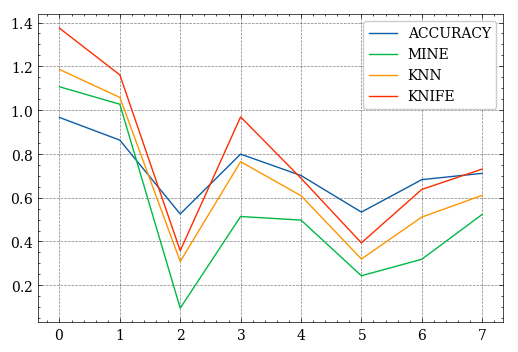

In [62]:
with plt.style.context(['science','no-latex','grid']):
    plt.figure(figsize=(6, 4))
    plt.plot(result_df['ACCURACY'],label = 'ACCURACY')
    plt.plot(result_df['MINE'],label = 'MINE')
    # plt.plot(result_df['KERNEL'],label = 'KERNEL')
    plt.plot(result_df['KNN'],label = 'KNN')
    plt.plot(result_df['KNIFE'],label = 'KNIFE')
    plt.legend(loc='upper right')

In [63]:
transformations = [
    # ['identity'],
    ['crosscor'],
    # ['autocor', {'m':5000,'k':4}],
    ['fourier', {'new_dimension':40}],
    ['low_fourier'],
    ['low_psd'],
    # ['cwt',{'pca_components' : 10}],
    ['wavedec'],
    ['autoreg', {'k': 3}],
    ['shannon_encoding'],
    ['waveletscattering']
    # ['wavelet_leaders'],
    # ['multifracs'],
    # ['multifracs', {'j1':1,'j2':12}],
    # [['wavelet_leaders','shannon_encoding']],
    # [['wavelet_leaders','multifracs']],
    # [['fourier','multifracs',], {'new_dimension':40}],
    # [['fourier','multifracs',], {'new_dimension':40}],
    # [['fourier','multifracs','shannon_encoding'], {'new_dimension':40}],
    # [['low_fourier','multifracs','autoreg'], {'k':3}],
    
]

In [40]:
evaluate_transformations(Xecg, y, transformations)

Transformation: crosscor, Shape: 10 


epoch: 100%|██████████| 100/100 [02:05<00:00,  1.25s/it]


Transformation: fourier_new_dimension=40, Shape: 40 


epoch: 100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Transformation: low_fourier, Shape: 65 


epoch: 100%|██████████| 100/100 [02:34<00:00,  1.54s/it]


Transformation: low_psd, Shape: 65 


epoch: 100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


Transformation: wavedec, Shape: 240 


  8%|████                                                  | 750/10000 [00:13<02:46, 55.55step/s, test=0.10, train=0.31]


epoch: 100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


Transformation: autoreg_k=3, Shape: 3 


epoch: 100%|██████████| 100/100 [04:13<00:00,  2.53s/it]


Computing  shannon_encoding ...

In [ ]:
evaluate_transformations(Xhrv, y, transformations)

In [110]:


# task = bmi.benchmark.BENCHMARK_TASKS['1v1-normal-0.75']
# print(f"Task {task.name} with dimensions {task.dim_x} and {task.dim_y}")
# print(f"Ground truth mutual information: {task.mutual_information:.2f}")

# X, Y = task.sample(1000, seed=42)

# cca = bmi.estimators.CCAMutualInformationEstimator()
# print(f"Estimate by CCA: {cca.estimate(X, Y):.2f}")

# ksg = bmi.estimators.KSGEnsembleFirstEstimator(neighborhoods=(5,))
# print(f"Estimate by KSG: {ksg.estimate(X, Y):.2f}")

In [111]:
stop

NameError: name 'stop' is not defined

1

  8%|████                                                  | 750/10000 [00:12<02:32, 60.61step/s, test=1.08, train=1.09]
epoch: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]
{'KNN': 0.8502633542749152, 'KERNEL': 3.974147232935607, 'MINE': 1.1285080909729004, 'KNIFE': 1.338432982675501, 'ACCURACY': 0.9638888888888889}
  8%|████                                                  | 750/10000 [00:14<02:59, 51.56step/s, test=0.98, train=1.02]
epoch: 100%|██████████| 100/100 [02:35<00:00,  1.56s/it]
{'KNN': 1.0591526192050313, 'KERNEL': 1.902792204224614, 'MINE': 1.026944875717163, 'KNIFE': 1.1040772186316274, 'ACCURACY': 0.8634259259259259}
 10%|█████▎                                               | 1000/10000 [00:15<02:23, 62.94step/s, test=0.08, train=0.08]
WARNING: Smoothed raining MI was still increasing when training stopped: final=0.129 vs 100 step(s) ago=0.122
epoch: 100%|██████████| 100/100 [02:31<00:00,  1.51s/it]
{'KNN': 0.3480875458272994, 'KERNEL': 0.8999446483104094, 'MINE': 0.12139785289764404, 'KNIFE': 0.057890223868098944, 'ACCURACY': 0.2777777777777778}
  8%|████                                                  | 750/10000 [00:11<02:18, 66.58step/s, test=0.16, train=0.18]
WARNING: Smoothed training MI fell compared to highest value: max=0.628 vs final=0.230
epoch: 100%|██████████| 100/100 [02:25<00:00,  1.46s/it]
{'KNN': 0.8084928308817556, 'KERNEL': 1.735897686774666, 'MINE': 0.5140691995620728, 'KNIFE': 0.9373721642626658, 'ACCURACY': 0.8050925925925926}
 15%|███████▉                                             | 1500/10000 [00:28<02:43, 51.93step/s, test=0.49, train=0.48]
epoch: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]
{'KNN': 0.6602970921538454, 'KERNEL': 0.0777622290810005, 'MINE': 0.49768340587615967, 'KNIFE': 0.7024234542772634, 'ACCURACY': 0.6947530864197531}
  8%|████                                                  | 750/10000 [00:12<02:29, 62.07step/s, test=0.23, train=0.19]
WARNING: Smoothed raining MI was still increasing when training stopped: final=0.234 vs 75 step(s) ago=0.217
epoch: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]
{'KNN': 0.3345431445991274, 'KERNEL': 0.14679188626458528, 'MINE': 0.24144911766052246, 'KNIFE': 0.3925483974254471, 'ACCURACY': 0.541820987654321}
 10%|█████▎                                               | 1000/10000 [00:16<02:28, 60.58step/s, test=0.35, train=0.49]
epoch: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]
{'KNN': 0.5633935650857982, 'KERNEL': -0.1213142755827945, 'MINE': 0.37467455863952637, 'KNIFE': 0.6525536517808097, 'ACCURACY': 0.6756172839506173}
 12%|██████▋                                              | 1250/10000 [00:20<02:21, 61.73step/s, test=0.49, train=0.45]
epoch: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it]
{'KNN': 0.6427775503438813, 'KERNEL': 0.5484418115186608, 'MINE': 0.4871199131011963, 'KNIFE': 0.716050656499732, 'ACCURACY': 0.7021604938271605}

2

Transformation: crosscor, Shape: 10 
  8%|████                                                  | 750/10000 [00:11<02:24, 64.21step/s, test=0.23, train=0.21]
WARNING: Smoothed training MI fell compared to highest value: max=0.262 vs final=0.204
epoch: 100%|██████████| 100/100 [02:24<00:00,  1.45s/it]
Transformation: fourier_new_dimension=40, Shape: 40 
 12%|██████▋                                              | 1250/10000 [00:23<02:47, 52.18step/s, test=0.38, train=0.42]
epoch: 100%|██████████| 100/100 [02:50<00:00,  1.70s/it]
Transformation: low_fourier, Shape: 65 7811
  8%|████                                                  | 750/10000 [00:11<02:19, 66.40step/s, test=0.27, train=0.38]
epoch: 100%|██████████| 100/100 [02:33<00:00,  1.54s/it]
Transformation: low_psd, Shape: 65 : 0.3390
 18%|█████████▎                                           | 1750/10000 [00:28<02:13, 61.70step/s, test=0.09, train=0.47]
epoch: 100%|██████████| 100/100 [02:41<00:00,  1.62s/it]
Transformation: cwt_pca_components=10, Shape: 10 
  8%|████                                                  | 750/10000 [00:12<02:35, 59.55step/s, test=0.40, train=0.46]
epoch: 100%|██████████| 100/100 [02:31<00:00,  1.52s/it]
Transformation: wavedec, Shape: 240  0.8137
 10%|█████▎                                               | 1000/10000 [00:19<02:55, 51.23step/s, test=0.25, train=0.55]
epoch: 100%|██████████| 100/100 [02:44<00:00,  1.65s/it]
Transformation: autoreg_k=3, Shape: 3 .0029
 20%|██████████▌                                          | 2000/10000 [00:31<02:05, 63.61step/s, test=0.48, train=0.58]
epoch: 100%|██████████| 100/100 [02:34<00:00,  1.55s/it]
Transformation: shannon_encoding, Shape: 8 
 15%|███████▉                                             | 1500/10000 [00:27<02:34, 54.96step/s, test=0.73, train=0.71]
epoch: 100%|██████████| 100/100 [02:27<00:00,  1.48s/it]
Epoch [100/100], Step [80/81], Loss: 0.3663



In [40]:
class MyDataset(Dataset):

    def __init__(self, X, Y, labels):
        self.X = X
        self.Y = Y
        self.labels = labels
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Return the features and corresponding label at the given index
        return self.X[idx], self.Y[idx], self.labels[idx]

In [41]:
# from model.my_model import ConvNet
# import copy

In [42]:
class MyDataset(Dataset):

    def __init__(self, X, Y, labels):
        self.X = X
        self.Y = Y
        self.labels = labels
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Return the features and corresponding label at the given index
        return self.X[idx], self.Y[idx], self.labels[idx]

In [43]:
dataset = MyDataset(X=inputs_ecg,Y=outputs1,labels=torch.tensor(labels))

NameError: name 'inputs_ecg' is not defined

In [14]:
X,y,label = dataset[:]
X = np.array(X).squeeze()
y = np.array(y)
label = np.array(label)


In [15]:
X.shape

(5140, 3840)

In [16]:
res = mutual_info_classif(X,label)

In [18]:
for n in [3,10,50,100,300]:
    res = mutual_info_classif(y,label,n_neighbors=n)
    print(res)
    print(res.mean())

[0.6404705  0.57393381 0.61927569 0.58060789 0.59413071 0.50187154
 0.60830378 0.62696188 0.32441916 0.53262602 0.61225841 0.74059727
 0.48948113 0.59043673 0.54220141 0.45538354 0.37147048 0.50280187
 0.30205925 0.27534448 0.56806143 0.68974686 0.57530696 0.56609478
 0.66276285 0.72381776 0.79170604 0.69976952 0.35594996 0.53310458
 0.73651443 0.25047196]
0.5511857096775474
[0.63384949 0.56602845 0.6289287  0.58991649 0.60558246 0.51296952
 0.60294843 0.62982341 0.31535674 0.53276119 0.61623834 0.74128486
 0.48993895 0.58747691 0.54789223 0.46922131 0.35509732 0.50283769
 0.3025302  0.27304373 0.56164058 0.69962279 0.57169637 0.55783955
 0.66442238 0.71077282 0.78734242 0.70015154 0.35402105 0.53259765
 0.73623339 0.24535914]
0.5507945652957595
[0.63953696 0.57240928 0.63758452 0.59612831 0.61130032 0.51819036
 0.61575303 0.63328438 0.31412404 0.54161889 0.62323628 0.75339921
 0.49606786 0.59351975 0.55951108 0.48407816 0.35615827 0.50150089
 0.29434321 0.28054456 0.57796053 0.7098412

In [28]:
%pip install dtw-python

  Obtaining dependency information for dtw-python from https://files.pythonhosted.org/packages/32/9f/e0b91a75a810bec321909ed910ee5fca7ba6b7808f5e0f389d90d46623e8/dtw_python-1.5.3-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/49.0 kB ? eta -:--:--
     -------- ------------------------------- 10.2/49.0 kB ? eta -:--:--
     ----------------------- -------------- 30.7/49.0 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 49.0/49.0 kB 355.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/376.2 kB ? eta -:--:--
   ---- ----------------------------------- 41.0/376.2 kB 2.0 MB/s eta 0:00:01
   ----------------------- ---------------- 225.3/376.2 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 376.2/376.2 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\aejog\anaconda3\lib\site-packages\appdirs-1.4.4-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at c:\users\aejog\anaconda3\lib\site-packages\kymatio-0.4.0.dev0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [31]:
import numpy as np
from dtw import dtw

# Example sequences
sequence1 = np.array([0, 1, 2, 3, 4, 5])
sequence2 = np.array([1, 2, 3, 4, 5, 6])

# Define a distance function (Euclidean distance is commonly used)
def euclidean_distance(x, y):
    return np.abs(x - y)

# Perform DTW
alignment = dtw(sequence1, sequence2)

# Display the alignment distance
print("DTW distance:", alignment.distance)

DTW distance: 2.0


In [34]:
y

array([[-1.0036287 , -0.33342677, -0.7028649 , ..., -0.02573977,
         0.37117124,  0.02566248],
       [-0.8337579 ,  0.35795164, -0.73773265, ...,  0.0935782 ,
         0.74977994,  0.07879715],
       [-0.934284  ,  0.2652989 , -0.62785053, ...,  0.01784897,
         0.8059541 ,  0.14918669],
       ...,
       [ 0.7639055 ,  0.04372032,  0.6465986 , ...,  0.9228038 ,
        -0.49429268,  0.39612967],
       [-0.6291675 ,  0.14245938, -0.36647016, ..., -0.02929656,
         0.5634943 ,  0.10434194],
       [-0.751663  , -0.10784094, -0.36594906, ...,  0.05336997,
         0.1765241 ,  0.31795323]], dtype=float32)

In [33]:
target = labels
print(target.shape)
data = y
# # Reference algorithm with for loops
mi_ref = discrete_continuous_info_ref(target, data, k=10, base=2)
print("Reference MI = ", mi_ref)

# Fast, approximate algorithm using KDTrees and vectorized queries
mi_fast = discrete_continuous_info_fast(target, data, k=10, base=2,eps=1e-5)
msg = "Difference too large to be true: found "+str(mi_fast)
assert abs(mi_ref - mi_fast) < 1e-10, msg
print("Fast MI = ", mi_fast)

(5140,)
Reference MI =  1.4995459098992576
Fast MI =  1.499545909899439


In [43]:
convnet = copy.deepcopy(model.ecg_conv)

In [47]:
class MINE(nn.Module):
    def __init__(self,zd_dim):
        super(MINE, self).__init__()
        self.convnet = convnet
        self.net = nn.Sequential(nn.Linear(32+zd_dim,64),nn.ReLU(),nn.Linear(64,32),nn.ReLU(),nn.Linear(32,1))#FF(args, zc_dim + zd_dim, zc_dim, 1)

    def forward(self, z_c, z_d,y=0):  # samples have shape [sample_size, dim]
        # shuffle and concatenate
        z_c = self.convnet(z_c)
        sample_size = z_d.shape[0]
        random_index = torch.randint(sample_size, (sample_size,)).long()

        z_d_shuffle = z_d[random_index]

        T0 = self.net(torch.cat([z_c, z_d], dim=-1))
        T1 = self.net(torch.cat([z_c, z_d_shuffle], dim=-1))

        mi = T0.mean() - (T1.squeeze().logsumexp(0) - math.log(sample_size))
        return mi, 0., 0.

    def learning_loss(self, z_c, z_d,y=0):
        return - self(z_c, z_d)[0]

In [ ]:
dataset = MyDataset(X=inputs_ecg,Y=outputs1,labels=torch.tensor(labels))
batch_size = 64
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model =  MINE(zd_dim=32)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
epochs = 100
mi_est_values = []
test_mi_est_values = []
test_mean_mi_est_values = []
step = 0
for epoch in tqdm(range(epochs), 'epoch'):
            # rho = mi_to_rho(mi_value, sample_dim)
            for batch_x, batch_y, batch_label in train_loader:
                # print(batch_x.shape)
                # print(batch_y.shape)
            # for step in tqdm(range(training_steps), 'Training Loop', position=0, leave=True):
            #     batch_x, batch_y = sample_correlated_gaussian(rho, dim=sample_dim, batch_size=batch_size,
            #                                                     to_cuda=torch.cuda.is_available(), cubic=cubic)
                # batch_x = torch.tensor(batch_x).float().to(device)
                # batch_y = torch.tensor(batch_y).float().to(device)
                model.eval()
                mi_est, _, _ = model(batch_x, batch_y, batch_label)
                mi_est_values.append(mi_est.item())
                print('train ', mi_est)
                model.train()

                model_loss = model.learning_loss(batch_x, batch_y, batch_label)

                optimizer.zero_grad()
                model_loss.backward()
                optimizer.step()

                del batch_x, batch_y, batch_label
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
                step += 1
                if step % 50 == 0:
                    step = 0
                    with torch.no_grad():
                        s = 0.
                        n = 0
                        for batch_x, batch_y, batch_label in test_loader:
                            n += 1
                            model.eval()
                            mi_est, _, _ = model(batch_x, batch_y, batch_label)
                            s += mi_est
                            print('test ', mi_est )
                            test_mi_est_values.append(mi_est.item())
                        
                        test_mean_mi_est_values.append(s/n)
                    del batch_x, batch_y, batch_label

            #print("finish training for %s with true MI value = %f" % (model.__class__.__name__, mi_value))
            # torch.save(model.state_dict(), "./model/%s_%d.pt" % (model.__class__.__name__, int(mi_value)))

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # end_time = time.time()
        # time_cost = end_time - start_time
        # print("model %s average time cost is %f s" % (model_name, time_cost / total_steps))
        # mi_results[model_name] = mi_est_values
        # plt.plot(mi_est_values)
        # plt.plot(test_mi_est_values)
plt.plot(test_mean_mi_est_values,color='r')
plt.show()

In [13]:
class CLUB(nn.Module):  # CLUB: Mutual Information Contrastive Learning Upper Bound
    '''
        This class provides the CLUB estimation to I(X,Y)
        Method:
            forward() :      provides the estimation with input samples
            loglikeli() :   provides the log-likelihood of the approximation q(Y|X) with input samples
        Arguments:
            zc_dim, zd_dim :         the dimensions of samples from X, Y respectively
            hidden_size :          the dimension of the hidden layer of the approximation network q(Y|X)
            z_c, z_d : samples from X and Y, having shape [sample_size, zc_dim/zd_dim]
    '''

    def __init__(self, zc_dim, zd_dim): # args,
        super(CLUB, self).__init__()
        self.use_tanh = False
        # self.p_mu = FF(args, zc_dim, zc_dim, zd_dim)
        # self.p_logvar = FF(args, zc_dim, zc_dim, zd_dim)
        self.p_mu = nn.Sequential(nn.Linear(zc_dim, zd_dim),
                                      nn.ReLU(),
                                      nn.Linear(zd_dim, zd_dim),
                                    )
        self.p_logvar = nn.Sequential(nn.Linear(zc_dim, zd_dim),
                                      nn.ReLU(),
                                      nn.Linear(zd_dim, zd_dim),
                                      nn.Tanh())

    def get_mu_logvar(self, z_c):
        mu = self.p_mu(z_c)
        logvar = self.p_logvar(z_c)
        if self.use_tanh:
            logvar = logvar.tanh()
        return mu, logvar

    def forward(self, z_c, z_d):
        mu, logvar = self.get_mu_logvar(z_c)

        # log of conditional probability of positive sample pairs
        positive = - (mu - z_d) ** 2 / 2. / logvar.exp()

        prediction_1 = mu.unsqueeze(1)  # shape [nsample,1,dim]
        z_d_1 = z_d.unsqueeze(0)  # shape [1,nsample,dim]

        # log of conditional probability of negative sample pairs
        negative = - ((z_d_1 - prediction_1) ** 2).mean(dim=1) / 2. / logvar.exp()
        mi = (positive.sum(-1) - negative.sum(-1)).mean()
        return mi, 0., 0.

    def learning_loss(self, z_c, z_d):  # unnormalized loglikelihood
        mu, logvar = self.get_mu_logvar(z_c)
        return -(-(mu - z_d) ** 2 / logvar.exp() - logvar).sum(1).mean(0)

    def I(self, *args, **kwargs):
        return self.forward(*args[:2], **kwargs)[0]


In [14]:
class MyClub(nn.Module):
    def __init__(self,zc_dim, zd_dim, sample=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv = ConvNet()
        if sample:
            # self.club = CLUBSample(x_dim=x_dim, y_dim=y_dim, hidden_size=32)
            self.club = CLUB(zc_dim=zc_dim, zd_dim=zd_dim)
        else:
            self.club = CLUB(zc_dim=zc_dim, zd_dim=zd_dim)

    def get_mu_logvar(self, z_c):
        z_c = self.conv(z_c)
        return self.club.get_mu_logvar(z_c)

    def forward(self, z_c, z_d):
        mu, logvar = self.get_mu_logvar(z_c)

        # log of conditional probability of positive sample pairs
        positive = - (mu - z_d) ** 2 / 2. / logvar.exp()

        prediction_1 = mu.unsqueeze(1)  # shape [nsample,1,dim]
        z_d_1 = z_d.unsqueeze(0)  # shape [1,nsample,dim]

        # log of conditional probability of negative sample pairs
        negative = - ((z_d_1 - prediction_1) ** 2).mean(dim=1) / 2. / logvar.exp()
        mi = (positive.sum(-1) - negative.sum(-1)).mean()
        return mi, 0., 0.

    def learning_loss(self, z_c, z_d):  # unnormalized loglikelihood
        mu, logvar = self.get_mu_logvar(z_c)
        return -(-(mu - z_d) ** 2 / logvar.exp() - logvar).sum(1).mean(0)

    def I(self, *args, **kwargs):
        return self.forward(*args[:2], **kwargs)[0]

In [15]:
def rho_to_mi(rho, dim):
    result = -dim / 2 * np.log(1 - rho ** 2)
    return result


def mi_to_rho(mi, dim):
    result = np.sqrt(1 - np.exp(-2 * mi / dim))
    return result

In [16]:
import time

In [17]:
from myknife import MyKNIFE

In [18]:
def main(cubic=True):
    # import os
    # os.environ['CUDA_VISIBLE_DEVICES'] = '2'

    #for seed in [1, 2 ,3, 4, 5, 6, 7, 8]:
    # set_seed(seed)
    lambda_ = 2

    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    # suffix = '9.07_{}_{}_{}'.format(cubic, lambda_, seed)
    suffix = "test"
    # sample_dim = 20
    batch_size = 64
    # hidden_size = 15
    learning_rate = 0.001
    training_steps = 50_000
    model_list =  ["MyKnife"]# ["MyClub"]  #"TUBA", "KNIFE" # CLUBSample

    mi_list = [2.0] #, 4.0, 6.0, 8.0, 10.0]  # , 12.0, 14.0, 16.0, 18.0, 20.0]

    total_steps = training_steps * len(mi_list)
    
    dataset = MyDataset(X=inputs_ecg,Y=outputs1,labels=torch.tensor(labels))
    train_ratio = 0.8
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders for the training and testing sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_iter = iter(test_loader)
    # train MI estimators with samples

    # train MI estimators with samples

    mi_results = dict()
    for model_name in tqdm(model_list, 'Models'):
        if model_name == "MyClub":
            model = MyClub(zc_dim=32,zd_dim=32)
            model.conv = convnet
        if model_name == "MyKnife":
            model = MyKNIFE(32,4)
            model.kernel_marg = copy.deepcopy(convnet)
            model.kernel_cond = copy.deepcopy(convnet)
        # elif model_name == 'Kernel_F':
        #     model = MIKernelEstimator(device, sample_dim // 2, sample_dim).to(device)
        # elif model_name == 'KNIFE':
        #     model = MIKernelEstimator(device, batch_size // 6, sample_dim, sample_dim, use_joint=True).to(device)
        # elif model_name == 'DOE':
        #     model = eval(model_name)(sample_dim, sample_dim).to(device)
        # else:
        #     model = eval(model_name)(sample_dim, sample_dim, hidden_size).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), learning_rate)

        mi_est_values = []
        test_mi_est_values = []
        test_mean_mi_est_values = []
        step = 0
        start_time = time.time()
        epochs = 60
        for epoch in tqdm(range(epochs), 'epoch'):
            # rho = mi_to_rho(mi_value, sample_dim)
            for batch_x, batch_y, batch_label in train_loader:
                # print(batch_x.shape)
                # print(batch_y.shape)
            # for step in tqdm(range(training_steps), 'Training Loop', position=0, leave=True):
            #     batch_x, batch_y = sample_correlated_gaussian(rho, dim=sample_dim, batch_size=batch_size,
            #                                                     to_cuda=torch.cuda.is_available(), cubic=cubic)
                # batch_x = torch.tensor(batch_x).float().to(device)
                # batch_y = torch.tensor(batch_y).float().to(device)
                model.eval()
                mi_est, _, _ = model(batch_x, batch_y, batch_label)
                mi_est_values.append(mi_est.item())

                model.train()

                model_loss = model.learning_loss(batch_x, batch_y, batch_label)

                optimizer.zero_grad()
                model_loss.backward()
                optimizer.step()

                del batch_x, batch_y, batch_label
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                
                step += 1
                if step % 50 == 0:
                    step = 0
                    with torch.no_grad():
                        s = 0.
                        n = 0
                        for batch_x, batch_y, batch_label in test_loader:
                            n += 1
                            model.eval()
                            mi_est, _, _ = model(batch_x, batch_y, batch_label)
                            s += mi_est
                            test_mi_est_values.append(mi_est.item())
                        test_mean_mi_est_values.append(s/n)
                    del batch_x, batch_y, batch_label

            #print("finish training for %s with true MI value = %f" % (model.__class__.__name__, mi_value))
            # torch.save(model.state_dict(), "./model/%s_%d.pt" % (model.__class__.__name__, int(mi_value)))

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        end_time = time.time()
        time_cost = end_time - start_time
        print("model %s average time cost is %f s" % (model_name, time_cost / total_steps))
        mi_results[model_name] = mi_est_values
        # plt.plot(mi_est_values)
        # plt.plot(test_mi_est_values)
        plt.plot(test_mean_mi_est_values,color='r')
        plt.show()

    import seaborn as sns
    import pandas as pd

    colors = sns.color_palette()

    EMA_SPAN = 200

    ncols = len(model_list)
    nrows = 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(3.1 * ncols, 3.4 * nrows))
    axs = np.ravel(axs)

    xaxis = np.array(list(range(total_steps)))
    yaxis_mi = np.repeat(mi_list, training_steps)

    for i, model_name in enumerate(model_list):
        plt.sca(axs[i])
        p1 = plt.plot(mi_results[model_name], alpha=0.4, color=colors[0])[0]  # color = 5 or 0
        plt.locator_params(axis='y', nbins=5)
        plt.locator_params(axis='x', nbins=4)
        mis_smooth = pd.Series(mi_results[model_name]).ewm(span=EMA_SPAN).mean()

        if i == 0:
            plt.plot(mis_smooth, c=p1.get_color(), label='$\\hat{I}$')
            plt.plot(yaxis_mi, color='k', label='True')
            plt.xlabel('Steps', fontsize=25)
            plt.ylabel('MI', fontsize=25)
            plt.legend(loc='upper left', prop={'size': 15})
        else:
            plt.plot(mis_smooth, c=p1.get_color())
            plt.yticks([])
            plt.plot(yaxis_mi, color='k')
            plt.xlabel('Steps', fontsize=25)

        # plt.ylim(0, 15.5)
        plt.xlim(0, total_steps)
        plt.title(model_name, fontsize=35)
        import matplotlib.ticker as ticker

        ax = plt.gca()
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        plt.xticks(horizontalalignment="right")
        # plt.subplots_adjust( )

    plt.gcf().tight_layout()
    # plt.savefig('mi_est_Gaussian_{}_copy.pdf'.format(suffix), bbox_inches=None)
    # plt.show()

    print('Second part')

    bias_dict = dict()
    var_dict = dict()
    mse_dict = dict()
    for i, model_name in tqdm(enumerate(model_list)):
        bias_list = []
        var_list = []
        mse_list = []
        for j in range(len(mi_list)):
            mi_est_values = mi_results[model_name][training_steps * (j + 1) - 500:training_steps * (j + 1)]
            est_mean = np.mean(mi_est_values)
            bias_list.append(np.abs(mi_list[j] - est_mean))
            var_list.append(np.var(mi_est_values))
            mse_list.append(bias_list[j] ** 2 + var_list[j])
        bias_dict[model_name] = bias_list
        var_dict[model_name] = var_list
        mse_dict[model_name] = mse_list

    # %%

    plt.style.use('default')  # ('seaborn-notebook')

    colors = list(plt.rcParams['axes.prop_cycle'])
    col_idx = [2, 4, 5, 1, 3, 0, 6, 7]

    ncols = 1
    nrows = 3
    fig, axs = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 3. * nrows))
    axs = np.ravel(axs)

    for i, model_name in enumerate(model_list):
        plt.sca(axs[0])
        plt.plot(mi_list, bias_dict[model_name], label=model_name, marker='d', color=colors[col_idx[i]]["color"])

        plt.sca(axs[1])
        plt.plot(mi_list, var_dict[model_name], label=model_name, marker='d', color=colors[col_idx[i]]["color"])

        plt.sca(axs[2])
        plt.plot(mi_list, mse_dict[model_name], label=model_name, marker='d', color=colors[col_idx[i]]["color"])

    ylabels = ['Bias', 'Variance', 'MSE']
    for i in range(3):
        plt.sca(axs[i])
        plt.ylabel(ylabels[i], fontsize=15)

        if i == 0:
            if cubic:
                plt.title('Cubic', fontsize=17)
            else:
                plt.title('Gaussian', fontsize=17)
        if i == 1:
            plt.yscale('log')
        if i == 2:
            plt.legend(loc='upper left', prop={'size': 12})
            plt.xlabel('MI Values', fontsize=15)

    plt.gcf().tight_layout()
    # plt.savefig('bias_variance_Gaussian_{}.pdf'.format(suffix), bbox_inches='tight')
    # plt.show()

epoch: 100%|██████████| 60/60 [2:17:35<00:00, 137.58s/it]


model MyKnife average time cost is 0.165101 s


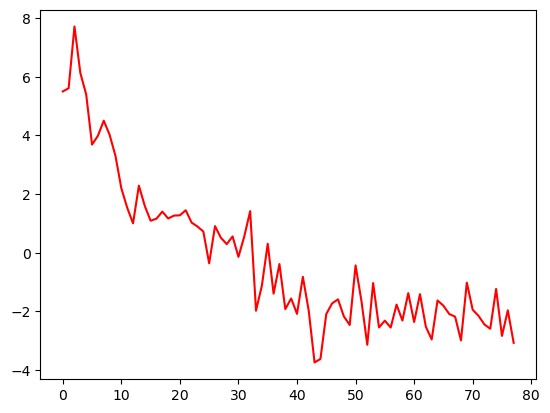

Models: 100%|██████████| 1/1 [2:17:35<00:00, 8255.77s/it]


Second part


0it [00:00, ?it/s]c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\aejog\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
1it [00:00, 124.96it/s]


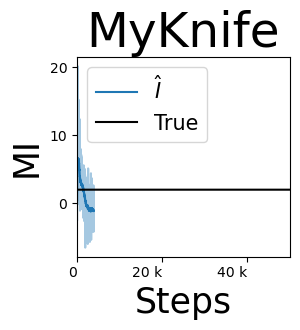

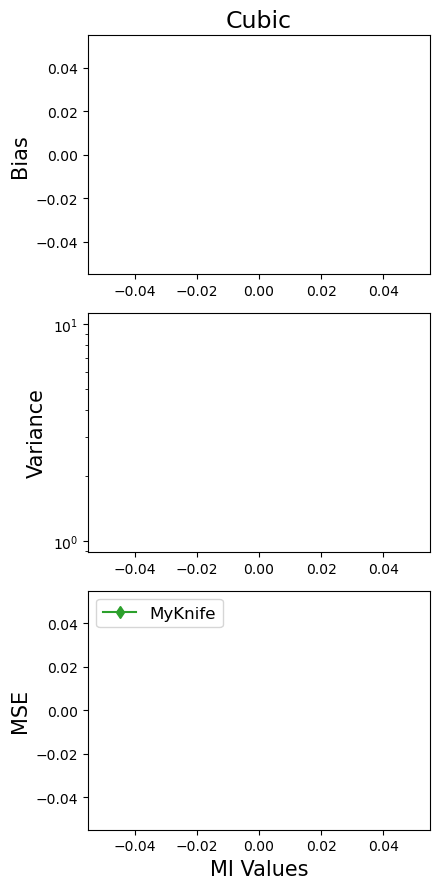

In [19]:
# main()